In [1]:
# Zachary Katz
# zachary_katz@mines.edu
# November 2024

"""
Plot Figure 3,4,S3,S4 for Whillans Catalog Paper
Figure 3: Events on top of tides
Figure 4: 45-Day Rolling Mean
Figure S3: 3-Day Rolling Mean
Figure S4: 27-Day Rolling Mean


v1.0: 01 November 2024
    Plots for Whillans Catalog Paper

"""

# Imports
import datetime
import sys

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker


import pandas as pd
import numpy as np
import scipy


from astropy.timeseries import LombScargle

from pyproj import CRS, Transformer
import shapefile
import shapely
from shapely.plotting import plot_line
from shapely.geometry import LineString

sys.path.insert(
    0,
    "/mnt/c/Users/ZacharyKatz/Desktop/WhillansCatPaper/WhillansCatalogPaper/src/Tides",
)
import Tides

################################################################################
########################## User Defined Variables ##############################

min_stas = 2  # Which catalog to use
tide_dir = "/mnt/c/Users/ZacharyKatz/Desktop/Research/Background"
tide_mod = "CATS2008-v2023"

########################## User Defined Variables ##############################
################################################################################

In [2]:
# Load slip times based on second derivative
ev_data = {"event": [], "trace_time": []}
df = pd.read_csv(f"../AllEventStartTimes_{min_stas}stas.txt", sep="\t")
ev_data["ev_time"] = df["EventStartTime"]

# Load no data from txt file
no_data = {"interval": [], "starts": [], "ends": []}
df = pd.read_csv(f"../no_data_{min_stas}stas.txt", sep="\t")
no_data["starts"] = df["start"]
no_data["ends"] = df["end"]
diff = [
    datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S")
    - datetime.datetime.strptime(y, "%Y-%m-%d %H:%M:%S")
    for x, y in zip(no_data["ends"], no_data["starts"])
]
no_data["interval"] = diff

In [3]:
# Calculate time since last events
time_since_last_ev = [
    datetime.timedelta(seconds=1000000)
]  # Set large for first event because prior event time unknown
for i, event in enumerate(ev_data["ev_time"]):
    if i > 0:
        diff = datetime.datetime.strptime(
            ev_data["ev_time"][i], "%Y-%m-%d %H:%M:%S"
        ) - datetime.datetime.strptime(ev_data["ev_time"][i - 1], "%Y-%m-%d %H:%M:%S")
        time_since_last_ev.append(diff)
ev_data["time_since_last_ev"] = time_since_last_ev
print([(a.days * 24 * 3600 + a.seconds) / 3600 for a in ev_data["time_since_last_ev"]])

[277.77777777777777, 17.354166666666668, 21.766666666666666, 10.758333333333333, 13.254166666666666, 19.1125, 22.970833333333335, 10.4875, 11.895833333333334, 9.975, 14.345833333333333, 9.975, 14.845833333333333, 9.9875, 14.658333333333333, 12.0625, 13.1375, 9.808333333333334, 15.225, 10.9875, 14.591666666666667, 10.625, 15.1, 23.866666666666667, 8.416666666666666, 16.3375, 21.929166666666667, 10.666666666666666, 14.5875, 18.954166666666666, 14.941666666666666, 10.7375, 20.645833333333332, 13.025, 12.041666666666666, 11.0125, 13.125, 9.525, 15.145833333333334, 8.875, 15.625, 8.2875, 16.266666666666666, 8.525, 16.9125, 8.5125, 16.4875, 8.55, 19.804166666666667, 16.733333333333334, 11.6625, 12.2, 12.983333333333333, 13.9, 21.4, 20.2, 12.008333333333333, 11.979166666666666, 11.516666666666667, 12.891666666666667, 11.183333333333334, 13.1125, 11.1, 13.5125, 11.545833333333333, 13.420833333333333, 10.85, 14.083333333333334, 10.420833333333333, 14.325, 11.045833333333333, 16.941666666666666,

[(-174.11568595746584, -84.38504722396503), (-174.07363790894706, -84.38708087490528), (-174.03252834334145, -84.38929637003153), (-173.9941263318061, -84.39193572017322), (-173.95194821792526, -84.39181611372216), (-173.90710899077706, -84.39045168887456), (-173.86118811502547, -84.38949590176401), (-173.8148291962652, -84.38878233553352), (-173.76803047357416, -84.38841239171828), (-173.72112609045024, -84.38834365932638), (-173.6742274584149, -84.38855870689241), (-173.62764576571297, -84.38910967700275), (-173.5814536310214, -84.38993610577346), (-173.53591166420026, -84.3910466307691), (-173.49112552234823, -84.39243260584267), (-173.44773757602218, -84.39419044387766), (-173.40529722592322, -84.39616056496061), (-173.36429498918946, -84.39840763385244), (-173.32440343132876, -84.40084127031444), (-173.28402159579116, -84.40319834133297), (-173.24328319333878, -84.40550028801066), (-173.20251122152564, -84.4077994127134), (-173.16170568018524, -84.41009571193077), (-173.1203332639

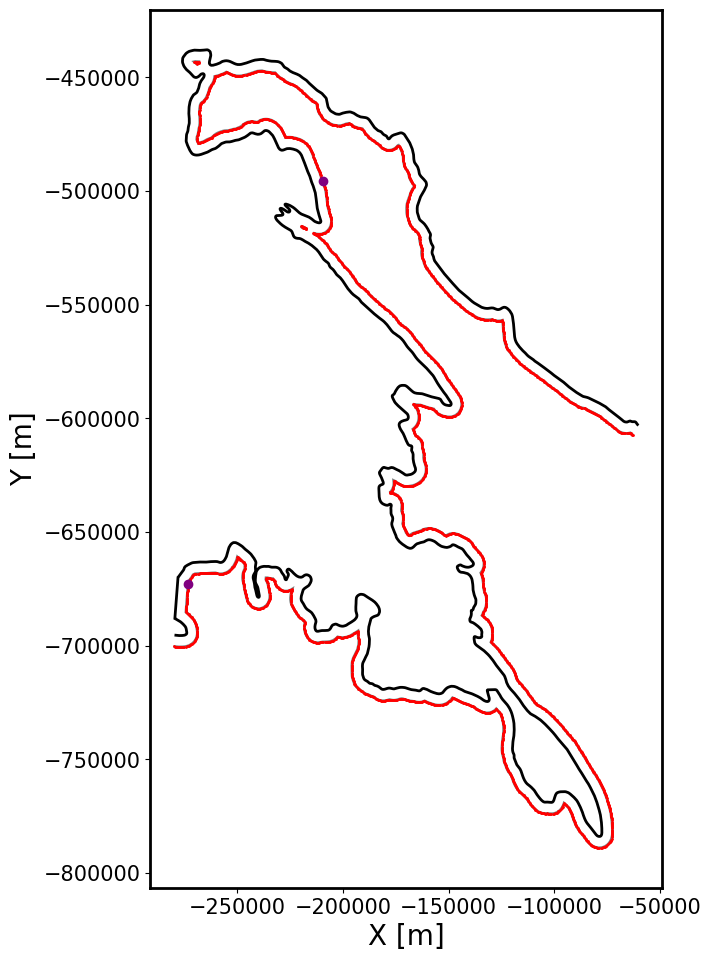

In [4]:
# Calculate difference in tides across basin at event times (from icesat2/gztides.ipynb)
# Helper functions
def inBox(points, bbox):
    # Return points from points that are in bbox
    inbox = []
    for point in points:
        x = point[0]
        y = point[1]
        if x > bbox[0] and x < bbox[2] and y > bbox[1] and y < bbox[3]:
            inbox.append(point)
    return inbox


def interpolateLine(line, dist):
    # Return a new list of points from a linestring that has been interpolated at
    # distance dist. Line must be linestring, dist in m for our case

    # Follows example from:
    # https://stackoverflow.com/questions/34906124/interpolating-every-x-distance-along-multiline-in-shapely
    length = shapely.length(line)
    num_vert = int(np.round(length / dist))
    # print(num_vert)
    return [line.interpolate(n * dist) for n in range(num_vert)]


def xy2ll(x, y):
    """
     Transform coordinates to geodetic coordinates (lon, lat)
     from Antarctic Polar Stereograph coordinates (x, y)

    lon,lat = xy2ll(x,y)
    """
    crs_ll = CRS("EPSG:4326")
    crs_xy = CRS("EPSG:3031")
    xy_to_ll = Transformer.from_crs(crs_xy, crs_ll, always_xy=True)
    lon, lat = xy_to_ll.transform(x, y)
    return lon, lat


def ll2xy(lon, lat):
    """
    Transform coordinates from input geodetic coordinates (lon, lat)
    to output Antarctic Polar Stereographic coordinates (x, y)
    Can also take lists of floats!

    Parameters
    lon - Geodetic longitude in EPSG:4326 [float]
    lat - Geodetic latitude in EPSG:4326 [float]

    Returns
    x - Antarctic Polar Stereographic (EPSG:3031) x [float]
    y - Antarctic Polar Stereographic (EPSG:3031) y [float]
    """

    crs_ll = CRS("EPSG:4326")
    crs_xy = CRS("EPSG:3031")
    ll_to_xy = Transformer.from_crs(crs_ll, crs_xy, always_xy=True)
    x, y = ll_to_xy.transform(lon, lat)
    return x, y


def dist_sq(x, y):
    # Returns min dist squared between two points
    delta_x = y[0] - x[0]
    delta_y = y[1] - x[1]
    return delta_x * delta_x + delta_y * delta_y


# Extract coordinates of grounding line

# Tuning parameters
offset = 5000  # Distance from grounding line to offset, m
pt_dist = 500  # Distance between tide sampling points, m

# Arrays to pass to tides
x_tide = []
y_tide = []

bbox = [-280000, -800000, -60000, -420000]  # Includes all of Crary
fig, ax = plt.subplots(
    figsize=[(bbox[2] - bbox[0]) / 100000 * 3, (bbox[3] - bbox[1]) / 100000 * 3]
)
# gl_path = '/mnt/d/Background/Antarctica_masks/scripps_antarctica_polygons_v1.shp'
gl_path = "/mnt/c/Users/ZacharyKatz/Desktop/Research/Background/Antarctica_masksX/scripps_antarctica_polygons_v1.shp"
sf = shapefile.Reader(gl_path)
for i, shape in enumerate(sf.shapes(bbox=bbox)):
    if i == 3:
        points = shape.points
        # Only get points within bounding box
        inbox = inBox(points, bbox)
        line = LineString(inbox)
        dilated = line.buffer(3000, single_sided=True)
        offset_line = line.offset_curve(offset)
        plot_line(line, ax=ax, add_points=False, color="black")
        plot_line(offset_line, ax=ax, add_points=False, color="gray")
        # plot_polygon(dilated, ax=ax, add_points=False, color='black')

        interpolated = interpolateLine(offset_line, pt_dist)
        xs = [point.x for point in interpolated]
        ys = [point.y for point in interpolated]
        ax.scatter(xs, ys, s=1, color="red")
        x_tide.append(xs)
        y_tide.append(ys)

ax.xaxis.set_major_locator(ticker.MultipleLocator(50000))
ax.yaxis.set_major_locator(ticker.MultipleLocator(50000))
ax.set_xlabel("X [m]", size=20)
ax.set_ylabel("Y [m]", size=20)
ax.tick_params(labelsize=15)

# Flatten the list. Not sure why this works but here's the source
# https://www.scaler.com/topics/flatten-list-python/
x_tide = sum(x_tide, [])
y_tide = sum(y_tide, [])

lon_lats = [xy2ll(x0, y0) for x0, y0 in zip(x_tide, y_tide)]
lons = [x[0] for x in lon_lats]
lats = [x[1] for x in lon_lats]
print(lon_lats)

ax.scatter(x_tide[800], y_tide[800], color="purple", zorder=2)
ax.scatter(x_tide[-100], y_tide[-100], color="purple", zorder=2)

print(lon_lats[800][0], lon_lats[800][1])
x_north = lon_lats[800][0]
y_north = lon_lats[800][1]
x_south = lon_lats[-100][0]
y_south = lon_lats[-100][1]
print(lon_lats[-100][0], lon_lats[-100][1])

In [39]:
# Tide time series at gz05
spacing = 4  # Minutes
dates_timeseries = []
initial_time = datetime.datetime.strptime("2007-12-01 00:00:00", "%Y-%m-%d %H:%M:%S")
for i in range(24 * 365 * 12 * 15):
    dates_timeseries.append(initial_time + datetime.timedelta(minutes=spacing * i))

lats = [-84.2986]
lons = [-164.5206]
places = ["gz05"]


tides = Tides.Tide(tide_mod, tide_dir)
for lat, lon, place in zip(lats, lons, places):
    ev_data[f"tides{place}"] = tides.tidal_elevation(
        [lon], [lat], dates_timeseries
    ).data.T[0]

In [35]:
# Tides at event times
times_to_calculate_tide = ev_data["ev_time"]

dates = [
    datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S") for x in times_to_calculate_tide
]

lats = [-84.2986]
lons = [-164.5206]
places = ["gz05"]

for lat, lon, place in zip(lats, lons, places):
    print(lat, lon, place)
    ev_data[f"tide_event_time_{place}"] = tides.tidal_elevation(
        [lon], [lat], dates
    ).data.T[0]

-84.2986 -164.5206 gz05


In [36]:
# Save tides at event times
df = pd.DataFrame(
    data={
        "time": ev_data["ev_time"],
        "tide_event_time": ev_data["tide_event_time_gz05"],
    }
)
df.to_csv("tide_event_time_gz05.txt", index=False, sep="\t")

In [40]:
# Calculate distance between event and nearest low and high tides
def dists(ev_data, place):
    # Calculate tidal maxima and minima for comparison

    # https://stackoverflow.com/questions/4624970/finding-local-maxima-minima-with-numpy-in-a-1d-numpy-array

    # Get as indices
    pks = scipy.signal.find_peaks(ev_data[f"tides{place}"], distance=60 / spacing * 3)[
        0
    ]  # Require 5 hrs between peaks
    vlys = scipy.signal.find_peaks(
        -1 * ev_data[f"tides{place}"], distance=60 / spacing * 3
    )[0]  # Require 5 hrs between valleys

    # Also save as times
    pk_times = [dates_timeseries[pk] for pk in pks]
    vly_times = [dates_timeseries[vly] for vly in vlys]

    # Find skipped low tide events (No event within +- 7 hrs of vly)
    skipped_lows = []
    events = [
        datetime.datetime.strptime(event, "%Y-%m-%d %H:%M:%S")
        for event in ev_data["ev_time"]
    ]
    for i, vly in enumerate(vlys):
        valley = dates_timeseries[vly]
        closest_event = min(events, key=lambda d: abs(d - valley))
        skipped = -1
        if abs(closest_event - valley) > datetime.timedelta(hours=6):
            skipped = 1
        skipped_lows.append(skipped)

    skipped_highs = []
    events = [
        datetime.datetime.strptime(event, "%Y-%m-%d %H:%M:%S")
        for event in ev_data["ev_time"]
    ]
    for i, pk in enumerate(pks):
        peak = dates_timeseries[pk]
        closest_event = min(events, key=lambda d: abs(d - peak))
        skipped = -1
        if abs(closest_event - peak) > datetime.timedelta(hours=6):
            skipped = 1
        skipped_highs.append(skipped)

    vly_date = [dates_timeseries[vly] for vly in vlys]
    vly_tide = [ev_data[f"tides{place}"][vly] for vly in vlys]

    pk_date = [dates_timeseries[pk] for pk in pks]
    pk_tide = [ev_data[f"tides{place}"][pk] for pk in pks]

    dist_to_highs = []
    dist_to_lows = []
    closest_highs = []
    closest_lows = []
    high_closers = []
    ht_to_highs = []
    ht_to_lows = []
    high_ht_closers = []
    for i, event in enumerate(ev_data["ev_time"]):
        event = datetime.datetime.strptime(event, "%Y-%m-%d %H:%M:%S")
        closest_high = min(pk_times, key=lambda d: abs(d - event))
        dist_to_high = event - closest_high
        closest_low = min(vly_times, key=lambda d: abs(d - event))

        ht_to_high = (
            ev_data[f"tide_event_time_{place}"][i]
            - ev_data[f"tides{place}"][pks[pk_times.index(closest_high)]]
        )
        ht_to_low = (
            ev_data[f"tide_event_time_{place}"][i]
            - ev_data[f"tides{place}"][vlys[vly_times.index(closest_low)]]
        )
        ht_to_highs.append(ht_to_high)
        ht_to_lows.append(ht_to_low)

        dist_to_low = event - closest_low
        dist_to_highs.append(dist_to_high)
        dist_to_lows.append(dist_to_low)
        closest_highs.append(closest_high)
        closest_lows.append(closest_low)

        if abs(dist_to_high) < abs(dist_to_low):
            high_closer = 1
        else:
            high_closer = 0
        high_closers.append(high_closer)

        if abs(ht_to_high) < abs(ht_to_low):
            high_closer = 1
        else:
            high_closer = 0
        high_ht_closers.append(high_closer)

    dist_dict = {
        "dist_to_highs": dist_to_highs,
        "dist_to_lows": dist_to_lows,
        "closest_highs": closest_highs,
        "closest_lows": closest_lows,
        "high_closers": high_closers,
        "ht_to_highs": ht_to_highs,
        "ht_to_lows": ht_to_lows,
        "high_ht_closers": high_ht_closers,
        "vly_date": vly_date,
        "vly_tide": vly_tide,
        "pk_date": pk_date,
        "pk_tide": pk_tide,
    }
    return dist_dict

In [42]:
dist_gz05 = dists(ev_data, "gz05")

In [43]:
print(dist_gz05["vly_date"])
print(dist_gz05["pk_date"])
spacing = 1  # Day
dates = []
initial_time = datetime.datetime.strptime("2010-12-12 00:00:00", "%Y-%m-%d %H:%M:%S")
for i in range(365 * 11):
    dates.append(initial_time + datetime.timedelta(days=spacing * i))

[datetime.datetime(2007, 12, 1, 6, 56), datetime.datetime(2007, 12, 1, 21, 32), datetime.datetime(2007, 12, 2, 7, 56), datetime.datetime(2007, 12, 2, 21, 56), datetime.datetime(2007, 12, 3, 8, 52), datetime.datetime(2007, 12, 3, 22, 24), datetime.datetime(2007, 12, 4, 9, 40), datetime.datetime(2007, 12, 4, 22, 48), datetime.datetime(2007, 12, 5, 10, 32), datetime.datetime(2007, 12, 5, 23, 8), datetime.datetime(2007, 12, 6, 11, 32), datetime.datetime(2007, 12, 6, 23, 32), datetime.datetime(2007, 12, 7, 23, 52), datetime.datetime(2007, 12, 9, 0, 24), datetime.datetime(2007, 12, 10, 0, 56), datetime.datetime(2007, 12, 11, 1, 36), datetime.datetime(2007, 12, 12, 2, 16), datetime.datetime(2007, 12, 13, 2, 52), datetime.datetime(2007, 12, 14, 3, 12), datetime.datetime(2007, 12, 15, 2, 40), datetime.datetime(2007, 12, 16, 2, 0), datetime.datetime(2007, 12, 17, 1, 40), datetime.datetime(2007, 12, 18, 0, 56), datetime.datetime(2007, 12, 18, 22, 28), datetime.datetime(2007, 12, 19, 21, 24), date

In [44]:
# Connect axes using https://matplotlib.org/stable/users/explain/text/annotations.html
from matplotlib.transforms import Bbox, TransformedBbox, blended_transform_factory

from mpl_toolkits.axes_grid1.inset_locator import (
    BboxPatch,
    BboxConnector,
    BboxConnectorPatch,
)


def connect_bbox(
    bbox1, bbox2, loc1a, loc2a, loc1b, loc2b, prop_lines, prop_patches=None
):
    if prop_patches is None:
        prop_patches = prop_lines.copy()
        prop_patches["alpha"] = prop_patches.get("alpha", 1) * 0.2

    c1 = BboxConnector(bbox1, bbox2, loc1=loc1a, loc2=loc2a, **prop_lines)
    c1.set_clip_on(False)
    c2 = BboxConnector(bbox1, bbox2, loc1=loc1b, loc2=loc2b, **prop_lines)
    c2.set_clip_on(False)

    bbox_patch1 = BboxPatch(bbox1, **prop_patches)
    bbox_patch2 = BboxPatch(bbox2, **prop_patches)

    p = BboxConnectorPatch(
        bbox1,
        bbox2,
        # loc1a=3, loc2a=2, loc1b=4, loc2b=1,
        loc1a=loc1a,
        loc2a=loc2a,
        loc1b=loc1b,
        loc2b=loc2b,
        **prop_patches,
    )
    p.set_clip_on(False)

    return c1, c2, bbox_patch1, bbox_patch2, p


def zoom_effect01(ax1, ax2, xmin, xmax, **kwargs):
    """
    ax1 : the main axes
    ax1 : the zoomed axes
    (xmin,xmax) : the limits of the colored area in both plot axes.

    connect ax1 & ax2. The x-range of (xmin, xmax) in both axes will
    be marked.  The keywords parameters will be used ti create
    patches.

    """

    trans1 = blended_transform_factory(ax1.transData, ax1.transAxes)
    trans2 = blended_transform_factory(ax2.transData, ax2.transAxes)

    bbox = Bbox.from_extents(xmin, 0, xmax, 1)

    mybbox1 = TransformedBbox(bbox, trans1)
    mybbox2 = TransformedBbox(bbox, trans2)

    prop_patches = kwargs.copy()
    prop_patches["ec"] = "none"
    prop_patches["alpha"] = 0.2

    c1, c2, bbox_patch1, bbox_patch2, p = connect_bbox(
        mybbox1,
        mybbox2,
        loc1a=3,
        loc2a=2,
        loc1b=4,
        loc2b=1,
        prop_lines=kwargs,
        prop_patches=prop_patches,
    )

    # ax1.add_patch(bbox_patch1)
    # ax2.add_patch(bbox_patch2)
    ax2.add_patch(c1)
    ax2.add_patch(c2)
    ax2.add_patch(p)

    return c1, c2, bbox_patch1, bbox_patch2, p

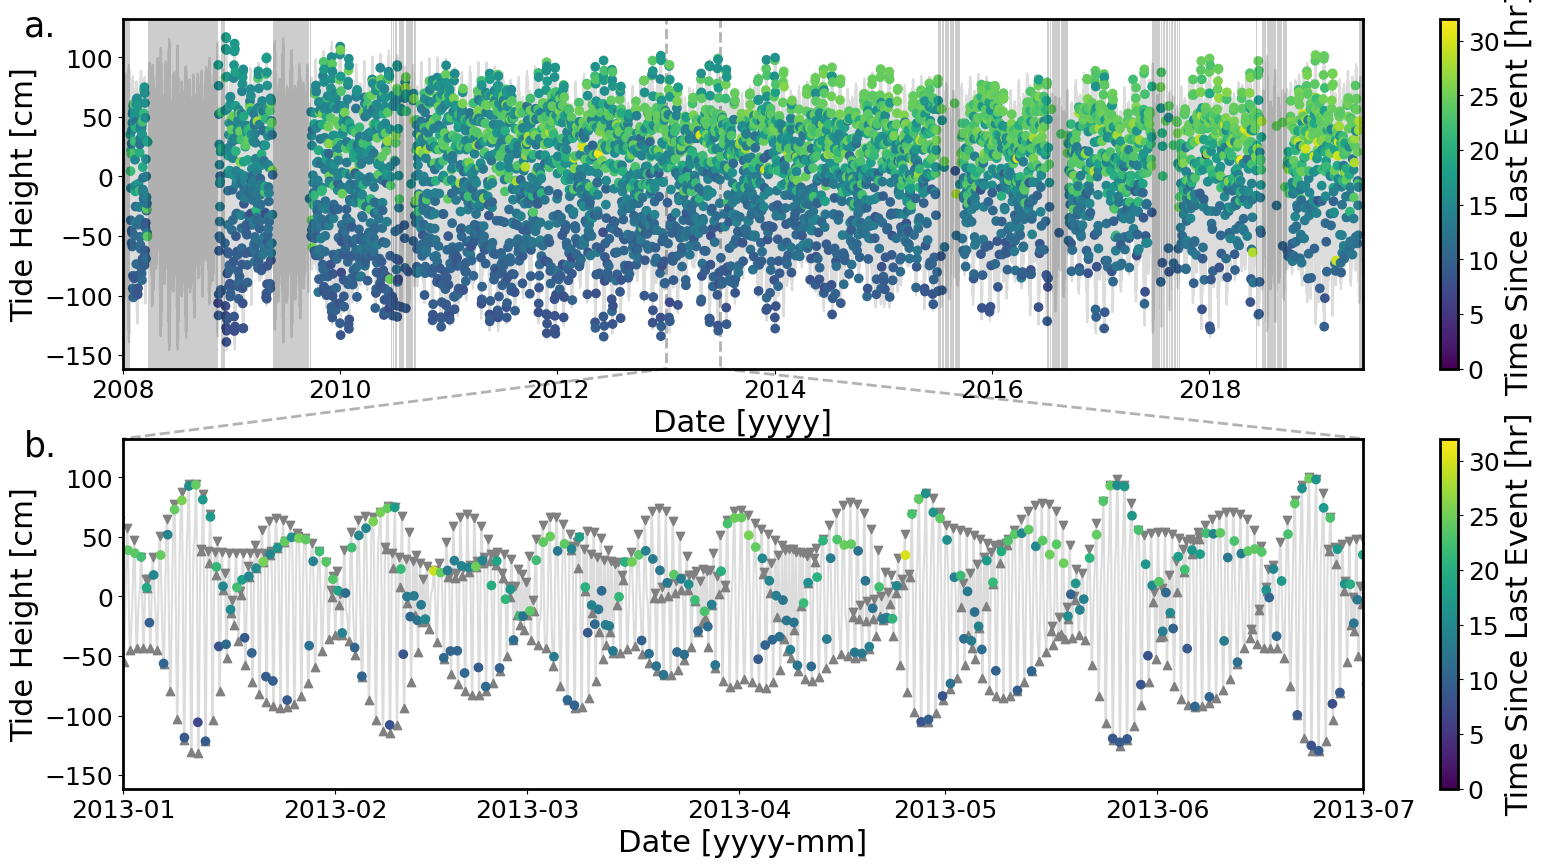

In [ ]:
# FIGURE 3
# Plot tides to see trends with diurnal tides
def subplot(ax, place, dist, st, ed, triangles=False):
    """Subplot for Figure 3. Plots tides and events colored by time since last event

    Parameters
    ----------
    ax : matplotlib.pyplot.axis
        Axis to plot on
    place : str
        Place tides are modeled at
    dist : dict
        Dict of high and low tides
    st : datetime.datetime
        Start time of panel
    ed : datetime.datetime
        End time of panel;
    triangles : bool, optional
        Flag to plot low and high tide triangles. Default is False.
    """
    ax.plot(dates_timeseries, ev_data[f"tides{place}"], zorder=0, color="gainsboro")
    if triangles:
        ax.scatter(dist["pk_date"], dist["pk_tide"], zorder=0, color="gray", marker="v")
        ax.scatter(
            dist["vly_date"], dist["vly_tide"], zorder=0, color="gray", marker="^"
        )
    hr_since_last_ev = [
        (a.days * 24 * 3600 + a.seconds) / 3600 for a in ev_data["time_since_last_ev"]
    ]
    masked_hr = np.ma.masked_where(np.array(hr_since_last_ev) > 32, ev_data["ev_time"])
    cax = ax.scatter(
        masked_hr,
        ev_data[f"tide_event_time_{place}"],
        c=hr_since_last_ev,
        zorder=2,
        cmap="viridis",
        vmin=0,
        vmax=32,
    )
    cbar = plt.colorbar(cax)
    cbar.set_label("Time Since Last Event [hr]", size=22)
    cbar.ax.tick_params(labelsize=18)
    ax.set_xlim(st, ed)
    # ax.set_xlim(datetime.datetime(2012,12,8),datetime.datetime(2013,5,20))
    ax.set_xlabel("Date [yyyy]", size=22)
    if triangles:
        ax.set_xlabel("Date [yyyy-mm]", size=22)
    ax.set_ylabel("Tide Height [cm]", size=22)
    ax.xaxis.set_tick_params(labelsize=18)
    ax.yaxis.set_tick_params(labelsize=18)

    for start, interval in zip(no_data["starts"][:], no_data["interval"][:]):
        start = datetime.datetime.strptime(start, "%Y-%m-%d %H:%M:%S")
        rect = plt.Rectangle(
            (start, -200), interval, 1000, facecolor="black", alpha=0.1, zorder=3
        )
        ax1.add_patch(rect)

    # ax.set_title(f'{place} Tide Reference',size=20)


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=[20, 10])
st = datetime.datetime(2007, 12, 1)
ed = datetime.datetime(2019, 6, 17)

st = datetime.datetime(2008, 1, 1)
ed = datetime.datetime(2019, 6, 1)

subplot(ax1, "gz05", dist_gz05, st, ed, triangles=False)
st = datetime.datetime(2013, 1, 1)
ed = datetime.datetime(2013, 7, 1)
rect = plt.Rectangle(
    (st, -200),
    ed - st,
    1000,
    facecolor="none",
    zorder=0,
    alpha=0.3,
    edgecolor="black",
    linewidth=2,
    linestyle="--",
)
ax1.add_patch(rect)


# st = datetime.datetime(2015, 12, 3)
# ed = datetime.datetime(2015, 12, 11)

subplot(ax2, "gz05", dist_gz05, st, ed, triangles=True)
# ax3 = ax2.twinx()
# ax3.plot(df["time"], df["dispEast"], color="red")
# ax3.plot(df["time"], df["disp"], color="red")
ax1.annotate("a.", (-0.08, 0.95), xycoords="axes fraction", fontsize=25)
ax2.annotate("b.", (-0.08, 0.95), xycoords="axes fraction", fontsize=25)

zoom_effect01(
    ax1,
    ax2,
    mdates.date2num(st),
    mdates.date2num(ed),
    ec="black",
    lw=2,
    alpha=0.3,
    ls="--",
)

plt.show()
fig.tight_layout()

In [46]:
# Find time since last event for all skipped low tides
time_since_last_event_low_pk = []
time_to_next_event_low_pk = []

events = np.ma.masked_where(
    np.array(dist_gz05["high_closers"]) == 1, ev_data["ev_time"]
)
events = np.ma.compressed(events)
tide_low = np.ma.masked_where(
    np.array(dist_gz05["high_closers"]) == 1, ev_data["tide_event_time_gz05"]
)
tide_low = np.ma.compressed(tide_low)

for i, valley in enumerate(dist_gz05["vly_date"]):
    closest_event = min(
        events,
        key=lambda d: abs(datetime.datetime.strptime(d, "%Y-%m-%d %H:%M:%S") - valley),
    )
    if datetime.datetime.strptime(closest_event, "%Y-%m-%d %H:%M:%S") > valley:
        closest_event = events[np.where(events == closest_event)[0] - 1][0]
    time_since_last_event_low_pk.append(
        valley - datetime.datetime.strptime(closest_event, "%Y-%m-%d %H:%M:%S")
    )

    closest_event = min(
        events,
        key=lambda d: abs(datetime.datetime.strptime(d, "%Y-%m-%d %H:%M:%S") - valley),
    )
    if datetime.datetime.strptime(closest_event, "%Y-%m-%d %H:%M:%S") < valley:
        try:
            closest_event = events[np.where(events == closest_event)[0] + 1][0]
        except IndexError:
            pass
    time_to_next_event_low_pk.append(
        datetime.datetime.strptime(closest_event, "%Y-%m-%d %H:%M:%S") - valley
    )

In [47]:
def rolling_average(
    window,
    slide_len,
    time_since_last_event_low_pk,
    time_to_next_event_low_pk,
    dist_gz05,
    ev_data,
    no_data,
):
    """Rolling average of slip events.

    Parameters
    ----------
    window : int
        Days to average over
    slide_len : int
        Days to slide window
    time_since_last_event_low_pk : list
        Times since last event
    time_to_next_event_low_pk : list
        Time to next event
    dist_gz05 : dict
        Dict of high and low tides
    ev_data : dict
        Dict of event data
    no_data : dict
        Dict of no data times
    """
    # Compute rolling average of skipped low slips

    time_since_low_hr = [a.total_seconds() / 3600 for a in time_since_last_event_low_pk]
    time_to_low_hr = [a.total_seconds() / 3600 for a in time_to_next_event_low_pk]

    mask = []
    for ts, tt in zip(time_since_low_hr, time_to_low_hr):
        if ts < 6 or tt < 6:
            mask.append(1)
        else:
            mask.append(0)

    masked_low_skips = np.ma.masked_where(mask, dist_gz05["vly_date"])
    masked_low_skips = np.ma.compressed(masked_low_skips)

    dates_timeseries_avg = []
    initial_time = datetime.datetime.strptime(
        "2007-12-01 00:00:00", "%Y-%m-%d %H:%M:%S"
    )

    time_to_append = window  # Days
    slide = slide_len  # Days

    # assert time_to_append % slide == 0
    interval = int(time_to_append // slide)  # MUST BE AN INTEGER

    rng = int(12 * 365 // slide)  # Range of times
    for i in range(rng):
        dates_timeseries_avg.append(initial_time + datetime.timedelta(days=slide * i))

    skips = []
    skip_starts = []
    skip_ends = []
    skip_middles = []
    tot_slips = []
    spacings = []

    for i, date in enumerate(dates_timeseries_avg):
        if i > interval:
            interval_start = dates_timeseries_avg[i - interval]
            interval_end = date

            # print(interval_start,interval_end)
            last_ev = datetime.datetime.strptime(
                ev_data["ev_time"].iloc[-1], "%Y-%m-%d %H:%M:%S"
            )
            first_ev = datetime.datetime.strptime(
                ev_data["ev_time"].iloc[0], "%Y-%m-%d %H:%M:%S"
            )
            stop = False
            for start, end in zip(no_data["starts"], no_data["ends"]):
                start = datetime.datetime.strptime(start, "%Y-%m-%d %H:%M:%S")
                end = datetime.datetime.strptime(end, "%Y-%m-%d %H:%M:%S")

                # Check that interval does not include gaps in data or start before 1st event or end after last event
                # if (interval_start > start and interval_start < end) or (interval_end > start and interval_end < end) \
                #    or (interval_start < end and interval_end > start) or (interval_start < start and interval_end > start) \
                #        or interval_start < first_ev \
                #        or interval_end > last_ev:
                #    stop = True

                if (
                    (interval_start < end and interval_end > start)
                    or interval_start < first_ev
                    or interval_end > last_ev
                ):
                    stop = True

            if not stop:
                # Number of total events
                slip = 0
                for event in ev_data["ev_time"]:
                    event = datetime.datetime.strptime(event, "%Y-%m-%d %H:%M:%S")
                    if event > interval_start and event < interval_end:
                        slip += 1

                # Number of low skips
                skip = 0
                for date_low in masked_low_skips:
                    if date_low > interval_start and date_low < interval_end:
                        skip += 1

                # Avg Event spacing
                spacing = 0
                counter = 0
                time_since = [
                    (a.days * 24 * 3600 + a.seconds) / 3600
                    for a in ev_data["time_since_last_ev"]
                ]
                for f, event in enumerate(ev_data["ev_time"]):
                    event = datetime.datetime.strptime(event, "%Y-%m-%d %H:%M:%S")
                    if event > interval_start and event < interval_end:
                        spacing += time_since[f]
                        counter += 1
                try:
                    spacing = spacing / counter
                except ZeroDivisionError:
                    spacing = np.nan
                # Avg Event amplitude

            else:
                skip = np.nan
                slip = np.nan
                spacing = np.nan

            skip_starts.append(interval_start)
            skip_ends.append(interval_end)
            skip_middles.append(interval_start + (interval_end - interval_start) / 2)
            skips.append(skip)
            tot_slips.append(slip)
            spacings.append(spacing)

    return skip_starts, skip_ends, skip_middles, skips, tot_slips, spacings

In [48]:
def annotation(ax, x1, x2, y1, y2, text):
    """Draws an annotated bracket."""
    xs = [x1, x1, x2, x2]
    ys = [y1, y2, y2, y1]
    ax.plot(xs, ys, "k-")
    ax.text((x2 - x1) / 2 + x1, y2 + 0.1, text, ha="center", va="bottom", fontsize=18)

In [50]:
slide = 1
rolling_avg_dicts = []
for window in [3, 27, 45]:
    skip_starts, skip_ends, skip_middles, skips, tot_slips, spacings = rolling_average(
        window,
        slide,
        time_since_last_event_low_pk,
        time_to_next_event_low_pk,
        dist_gz05,
        ev_data,
        no_data,
    )
    # Save as dict
    rolling_avg_dict = {
        "skip_starts": skip_starts,
        "skip_ends": skip_ends,
        "skip_middles": skip_middles,
        "skips": skips,
        "tot_slips": tot_slips,
        "spacings": spacings,
    }
    rolling_avg_dicts.append(rolling_avg_dict)

In [51]:
# Plotting function
def plot_rolling_avg_section(
    ax1,
    ax3,
    window,
    slide_len,
    skip_starts,
    skip_ends,
    skip_middles,
    skips,
    tot_slips,
    spacings,
):
    # Skipped slips by number of slips in xx period
    ax2 = ax1.twinx()
    (
        ax1.plot(
            dates_timeseries, ev_data["tidesgz05"], zorder=1, color="gray", alpha=0.4
        ),
    )
    for start, interval in zip(no_data["starts"][:], no_data["interval"][:]):
        start = datetime.datetime.strptime(start, "%Y-%m-%d %H:%M:%S")
        rect = plt.Rectangle(
            (start, -200), interval, 1000, facecolor="black", alpha=0.2, zorder=3
        )
        ax1.add_patch(rect)

    ax1.set_xlim(datetime.datetime(2008, 1, 1), datetime.datetime(2019, 6, 1))
    ax1.set_ylim(-120, 130)

    xerr = [(end - start) // 2 for start, end in zip(skip_starts, skip_ends)]
    norm_slips = [i / window for i in tot_slips]
    ax2.errorbar(skip_middles, norm_slips, xerr=xerr, fmt="o", color="black", zorder=2)
    # ax2.plot(skip_middles, tot_slips, color='blue')

    timestamps = [a.timestamp() for a in skip_middles]

    compressed_tot_slips = np.ma.masked_invalid(tot_slips)
    compressed_timestamps = np.ma.masked_where(
        np.ma.getmask(compressed_tot_slips), timestamps
    )
    compressed_tot_slips = np.ma.compressed(compressed_tot_slips)
    compressed_timestamps = np.ma.compressed(compressed_timestamps)

    coef = np.polyfit(compressed_timestamps, compressed_tot_slips, 1)
    print(coef)
    lst_sqrs_fit = np.poly1d(coef)
    print(lst_sqrs_fit[1])

    datetimes = [datetime.datetime.fromtimestamp(a) for a in compressed_timestamps]
    # ax2.plot(datetimes, lst_sqrs_fit(compressed_timestamps),color='blue',zorder=3)

    # Just a line so manually extract slope
    delta_y = (
        lst_sqrs_fit(compressed_timestamps)[-1] - lst_sqrs_fit(compressed_timestamps)[0]
    )
    delta_x = datetimes[-1] - datetimes[0]

    print(delta_y, delta_x)
    slope = delta_y / delta_x.total_seconds() * 3600 * 24 * 365
    print(slope)  # Slips / year
    ax1.yaxis.set_label_position("right")
    ax1.yaxis.tick_right()
    ax2.yaxis.set_label_position("left")
    ax2.yaxis.tick_left()
    ax1.set_xlabel("Date [yyyy]", size=22)
    ax1.set_ylabel("Tide Height [cm]", size=22)
    ax2.set_ylabel(f"Slips/Day [{window} Day Window]", size=22, color="black")
    ax1.xaxis.set_tick_params(labelsize=18)
    ax1.yaxis.set_tick_params(labelsize=18, color="gray")
    ax2.yaxis.set_tick_params(labelsize=18, colors="black")
    # ax2.spines['left'].set_color('red')

    ax4 = ax3.twinx()
    (
        ax3.plot(
            dates_timeseries, ev_data["tidesgz05"], zorder=1, color="gray", alpha=0.4
        ),
    )
    for start, interval in zip(no_data["starts"][:], no_data["interval"][:]):
        start = datetime.datetime.strptime(start, "%Y-%m-%d %H:%M:%S")
        rect = plt.Rectangle(
            (start, -200), interval, 1000, facecolor="black", alpha=0.2, zorder=3
        )
        ax3.add_patch(rect)

    st3 = datetime.datetime(2014, 1, 1)
    ed3 = datetime.datetime(2015, 6, 1)

    ax3.set_xlim(st3, ed3)
    # ax3.set_xlim(datetime.datetime(2008,12,8),datetime.datetime(2009,7,1))
    ax3.set_ylim(-155, 130)

    xerr = [(end - start) // 2 for start, end in zip(skip_starts, skip_ends)]
    # Segmet skipmiddles and norm_slips by date
    mask = [start > st3 and end < ed3 for start, end in zip(skip_middles, skip_ends)]
    skip_middles = np.array(skip_middles)[mask]
    norm_slips = np.array(norm_slips)[mask]
    xerr = np.array(xerr)[mask]

    ax4.errorbar(skip_middles, norm_slips, xerr=xerr, fmt="o", color="black", zorder=2)
    ax3.yaxis.set_label_position("right")
    ax3.yaxis.tick_right()
    ax4.yaxis.set_label_position("left")
    ax4.yaxis.tick_left()
    ax3.set_xlabel("Date [yyyy-mm]", size=22)
    ax3.set_ylabel("Tide Height [cm]", size=22)
    ax4.set_ylabel(f"Slips/Day [{window} Day Window]", size=22, color="black")
    ax3.xaxis.set_tick_params(labelsize=18)
    ax3.yaxis.set_tick_params(labelsize=18, color="gray")
    ax4.yaxis.set_tick_params(labelsize=18, colors="black")

    ssa_time = datetime.timedelta(days=182.63)
    ssa_start = datetime.datetime(2014, 3, 1)
    annotation(ax1, ssa_start, ssa_start + ssa_time, 92, 96, "$S_{sa}$")

    mm_time = datetime.timedelta(days=27.55)
    mm_start = datetime.datetime(2014, 6, 11)
    annotation(ax3, mm_start, mm_start + mm_time, 94, 98, "$M_{m}$")

    # ax1.set_title(f'{time_to_append} Day Rolling Average',size=22)

    ax1.set_title(f"{window} Day Window", size=22)
    # fig.tight_layout()

[-4.72210954e-09  1.09087618e+01]
-4.7221095431870305e-09
-1.684166812391097 4128 days, 0:00:00
-0.14891494344058875
27.574871966154536 Days, Power = 0.16214499626826087
14.769081693500299 Days, Power = 0.07828923321222668
13.682327919566902 Days, Power = 0.0732870284552016


/tmp/ipykernel_125658/1183862949.py:87: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


[-4.27633846e-08  9.84334903e+01]
-4.276338457238075e-08
-15.163126428443903 4104 days, 0:00:00
-1.3485724040891873
184.0340059790733 Days, Power = 0.3031840403211768
[-7.09428053e-08  1.63511547e+02]
-7.094280533625993e-08
-25.044711550882766 4086 days, 0:00:00
-2.2372294948781715
184.88499245852188 Days, Power = 0.3130367104740365
31.846908287866984 Days, Power = 0.0601659375960409
27.55197797257811 Days, Power = 0.1572578682649308


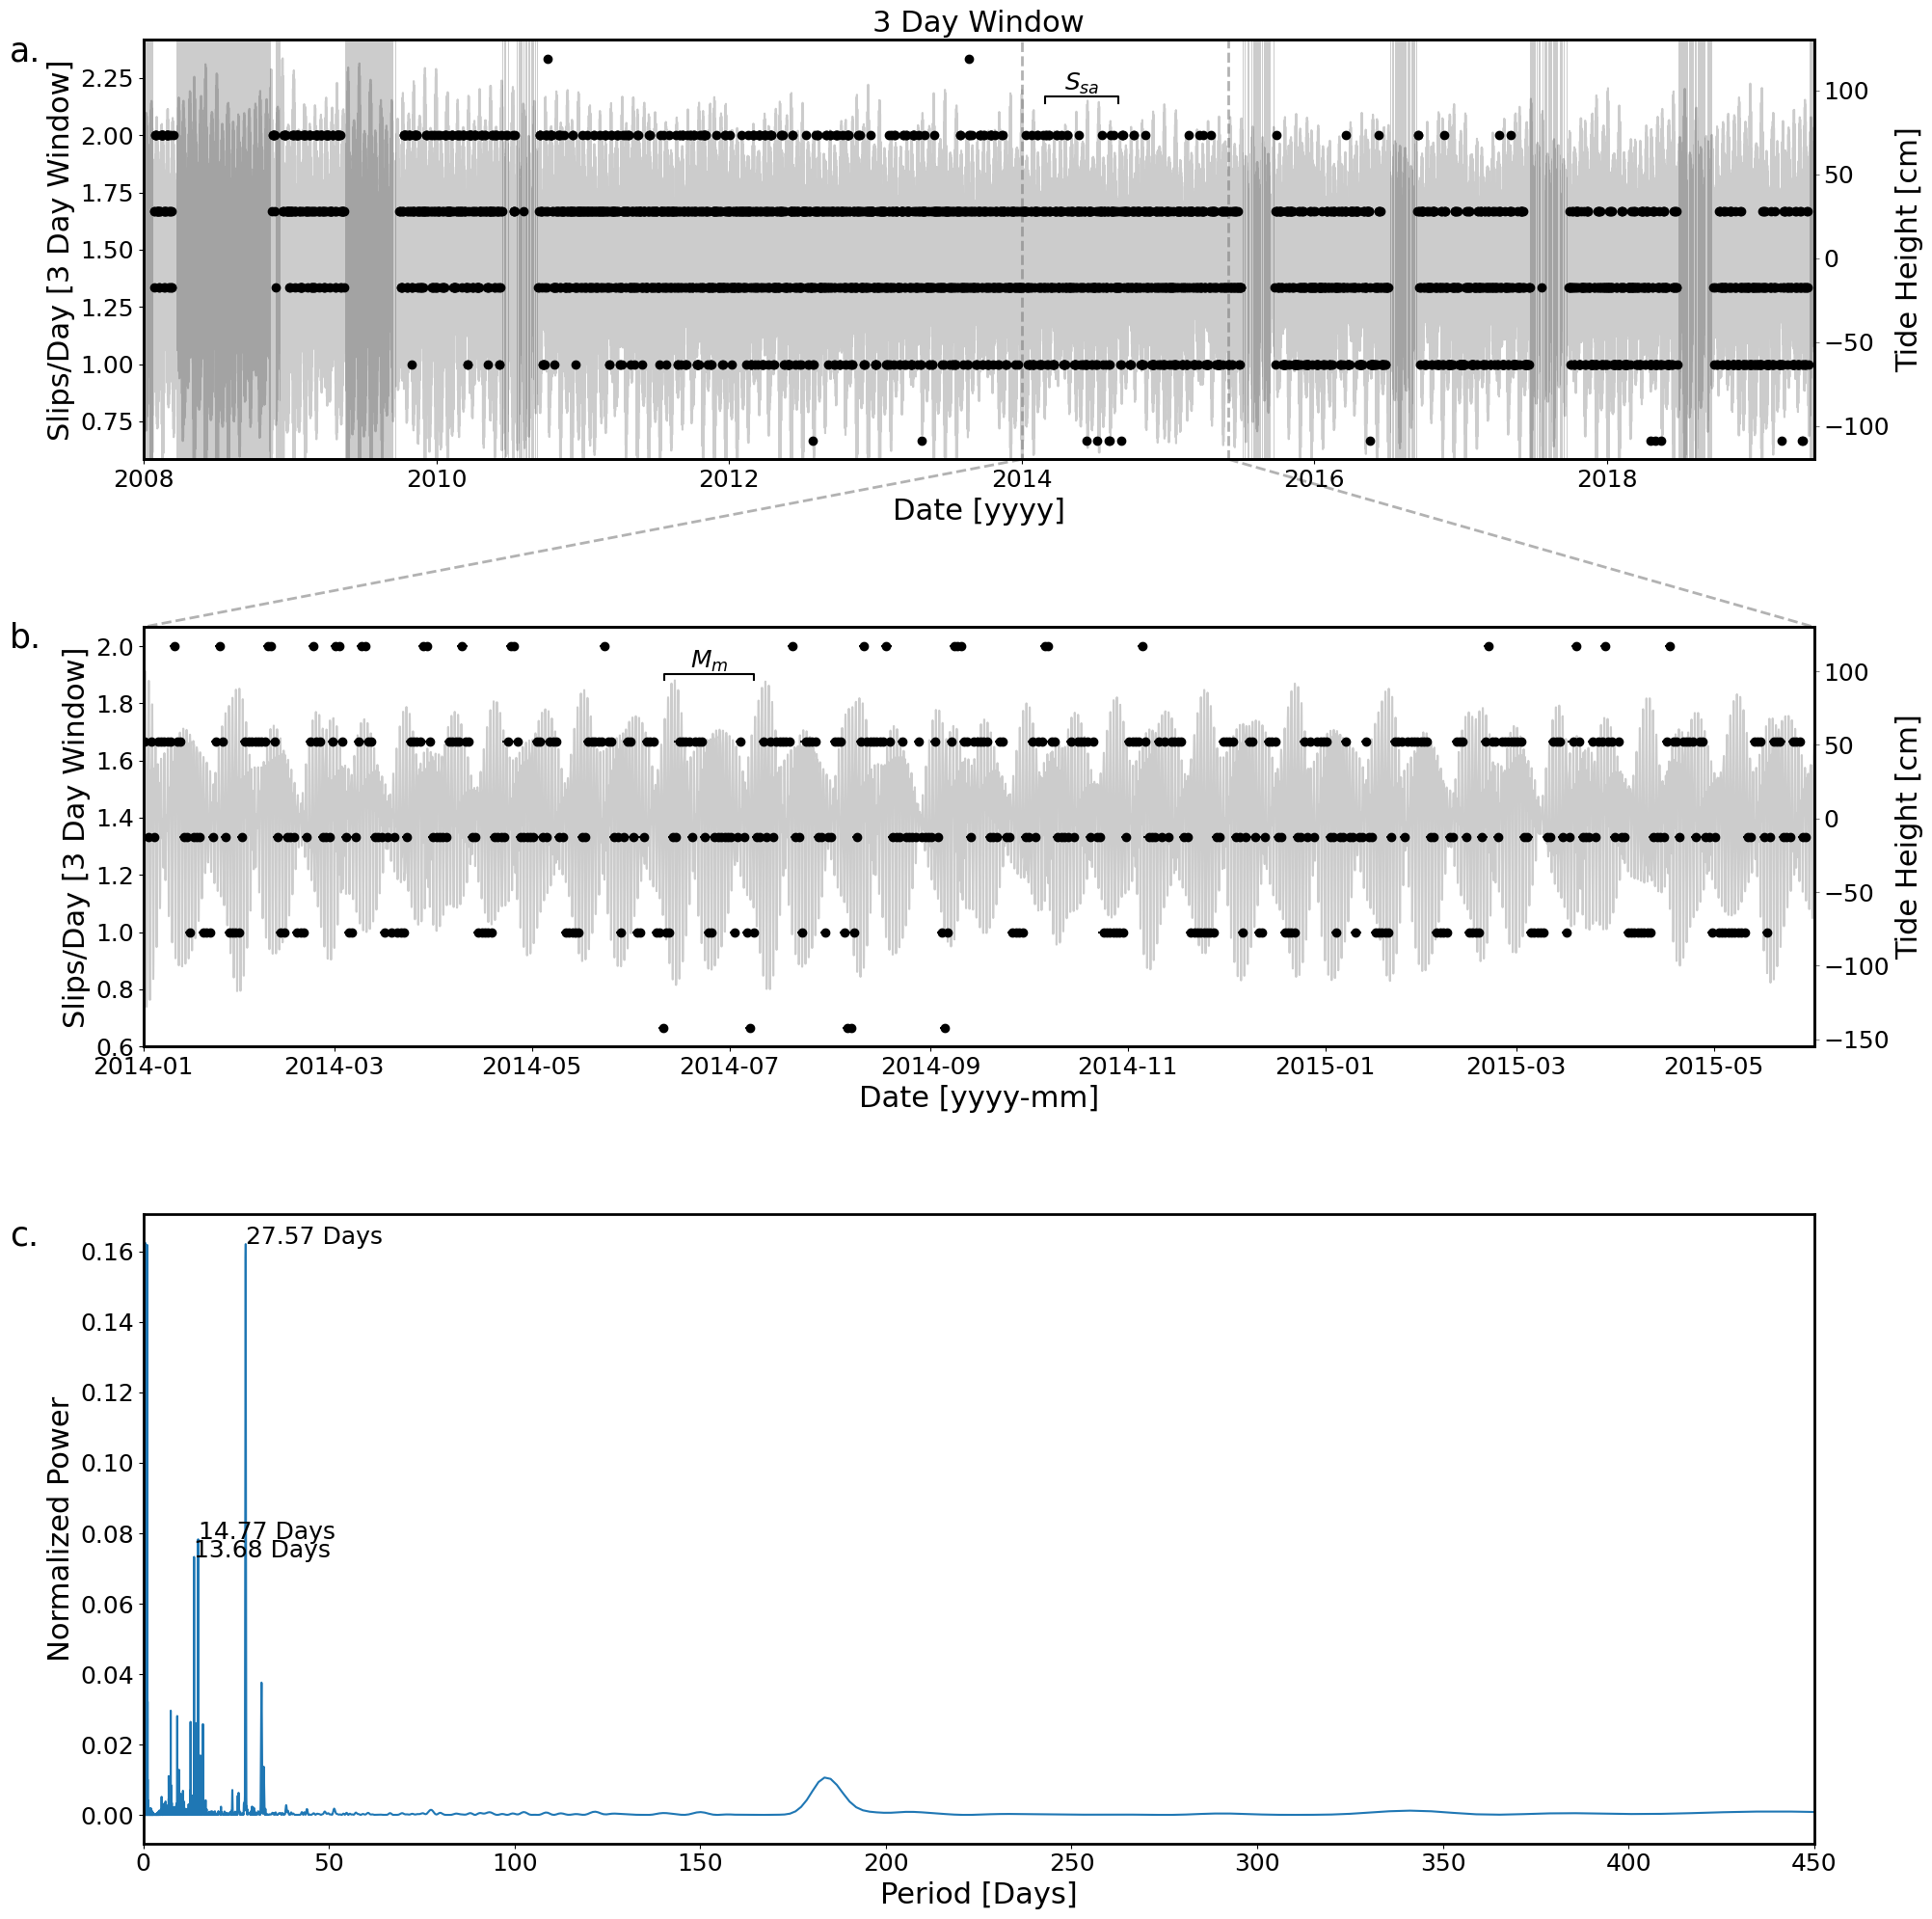

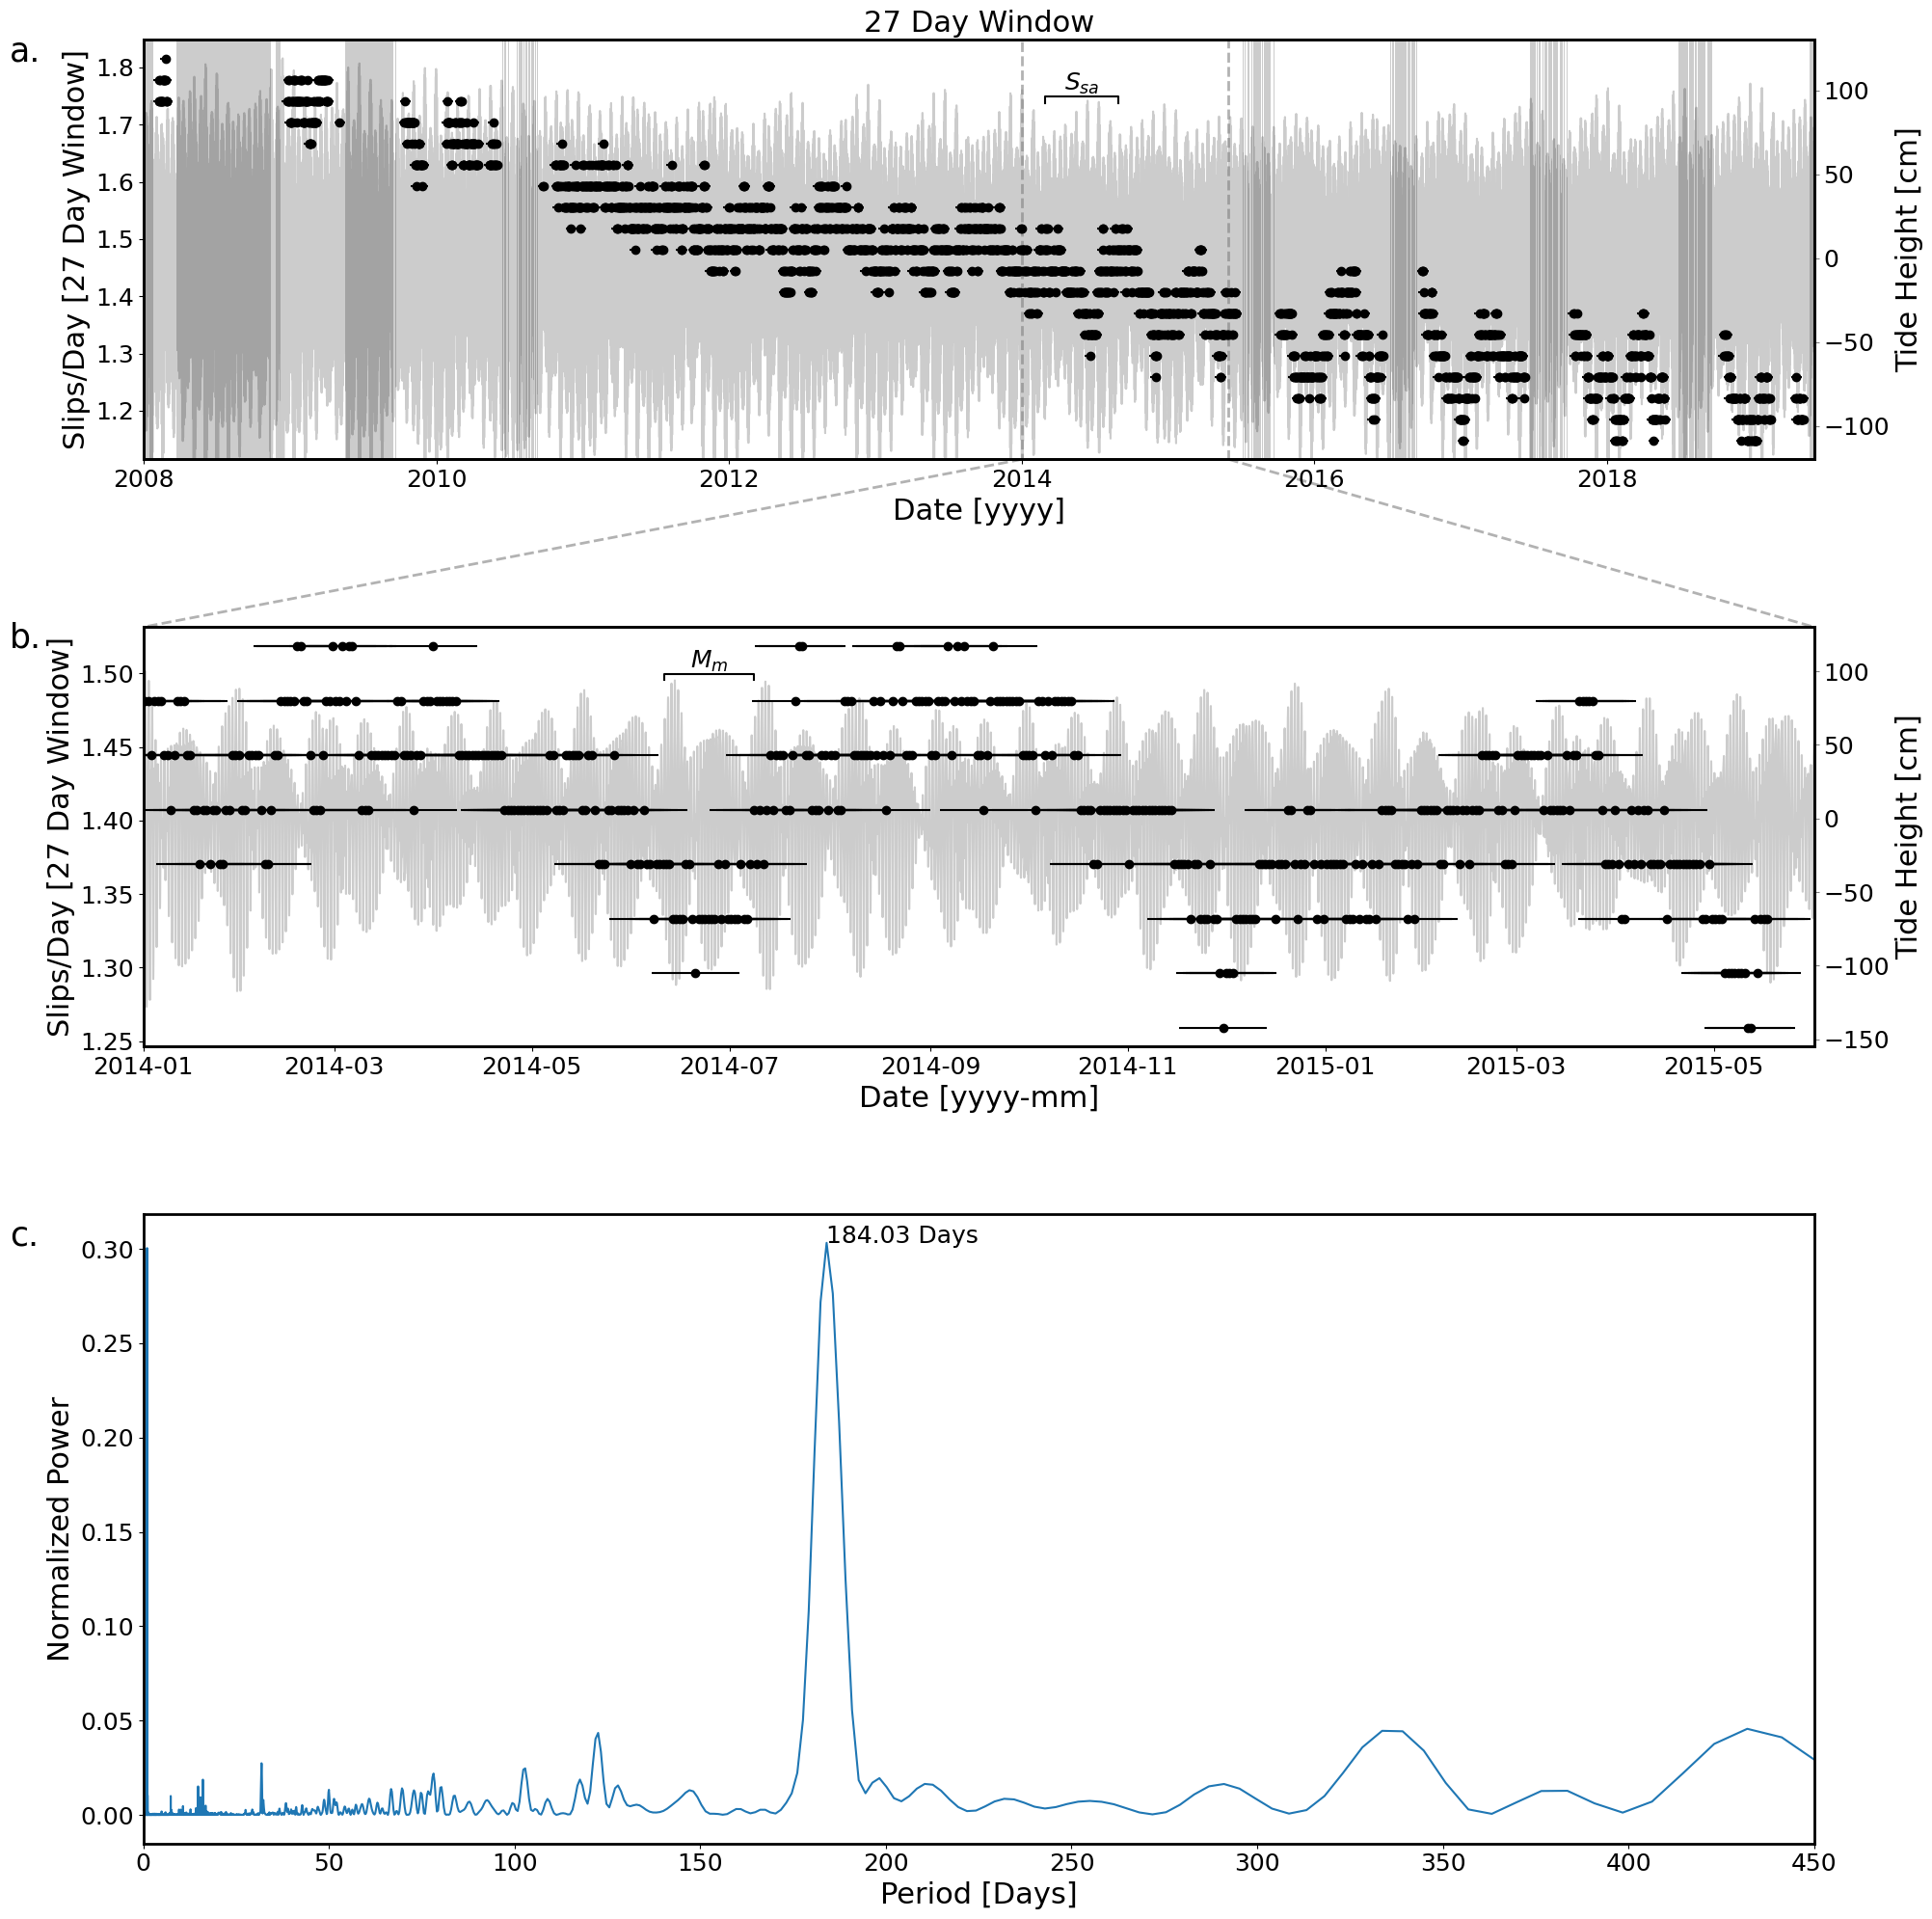

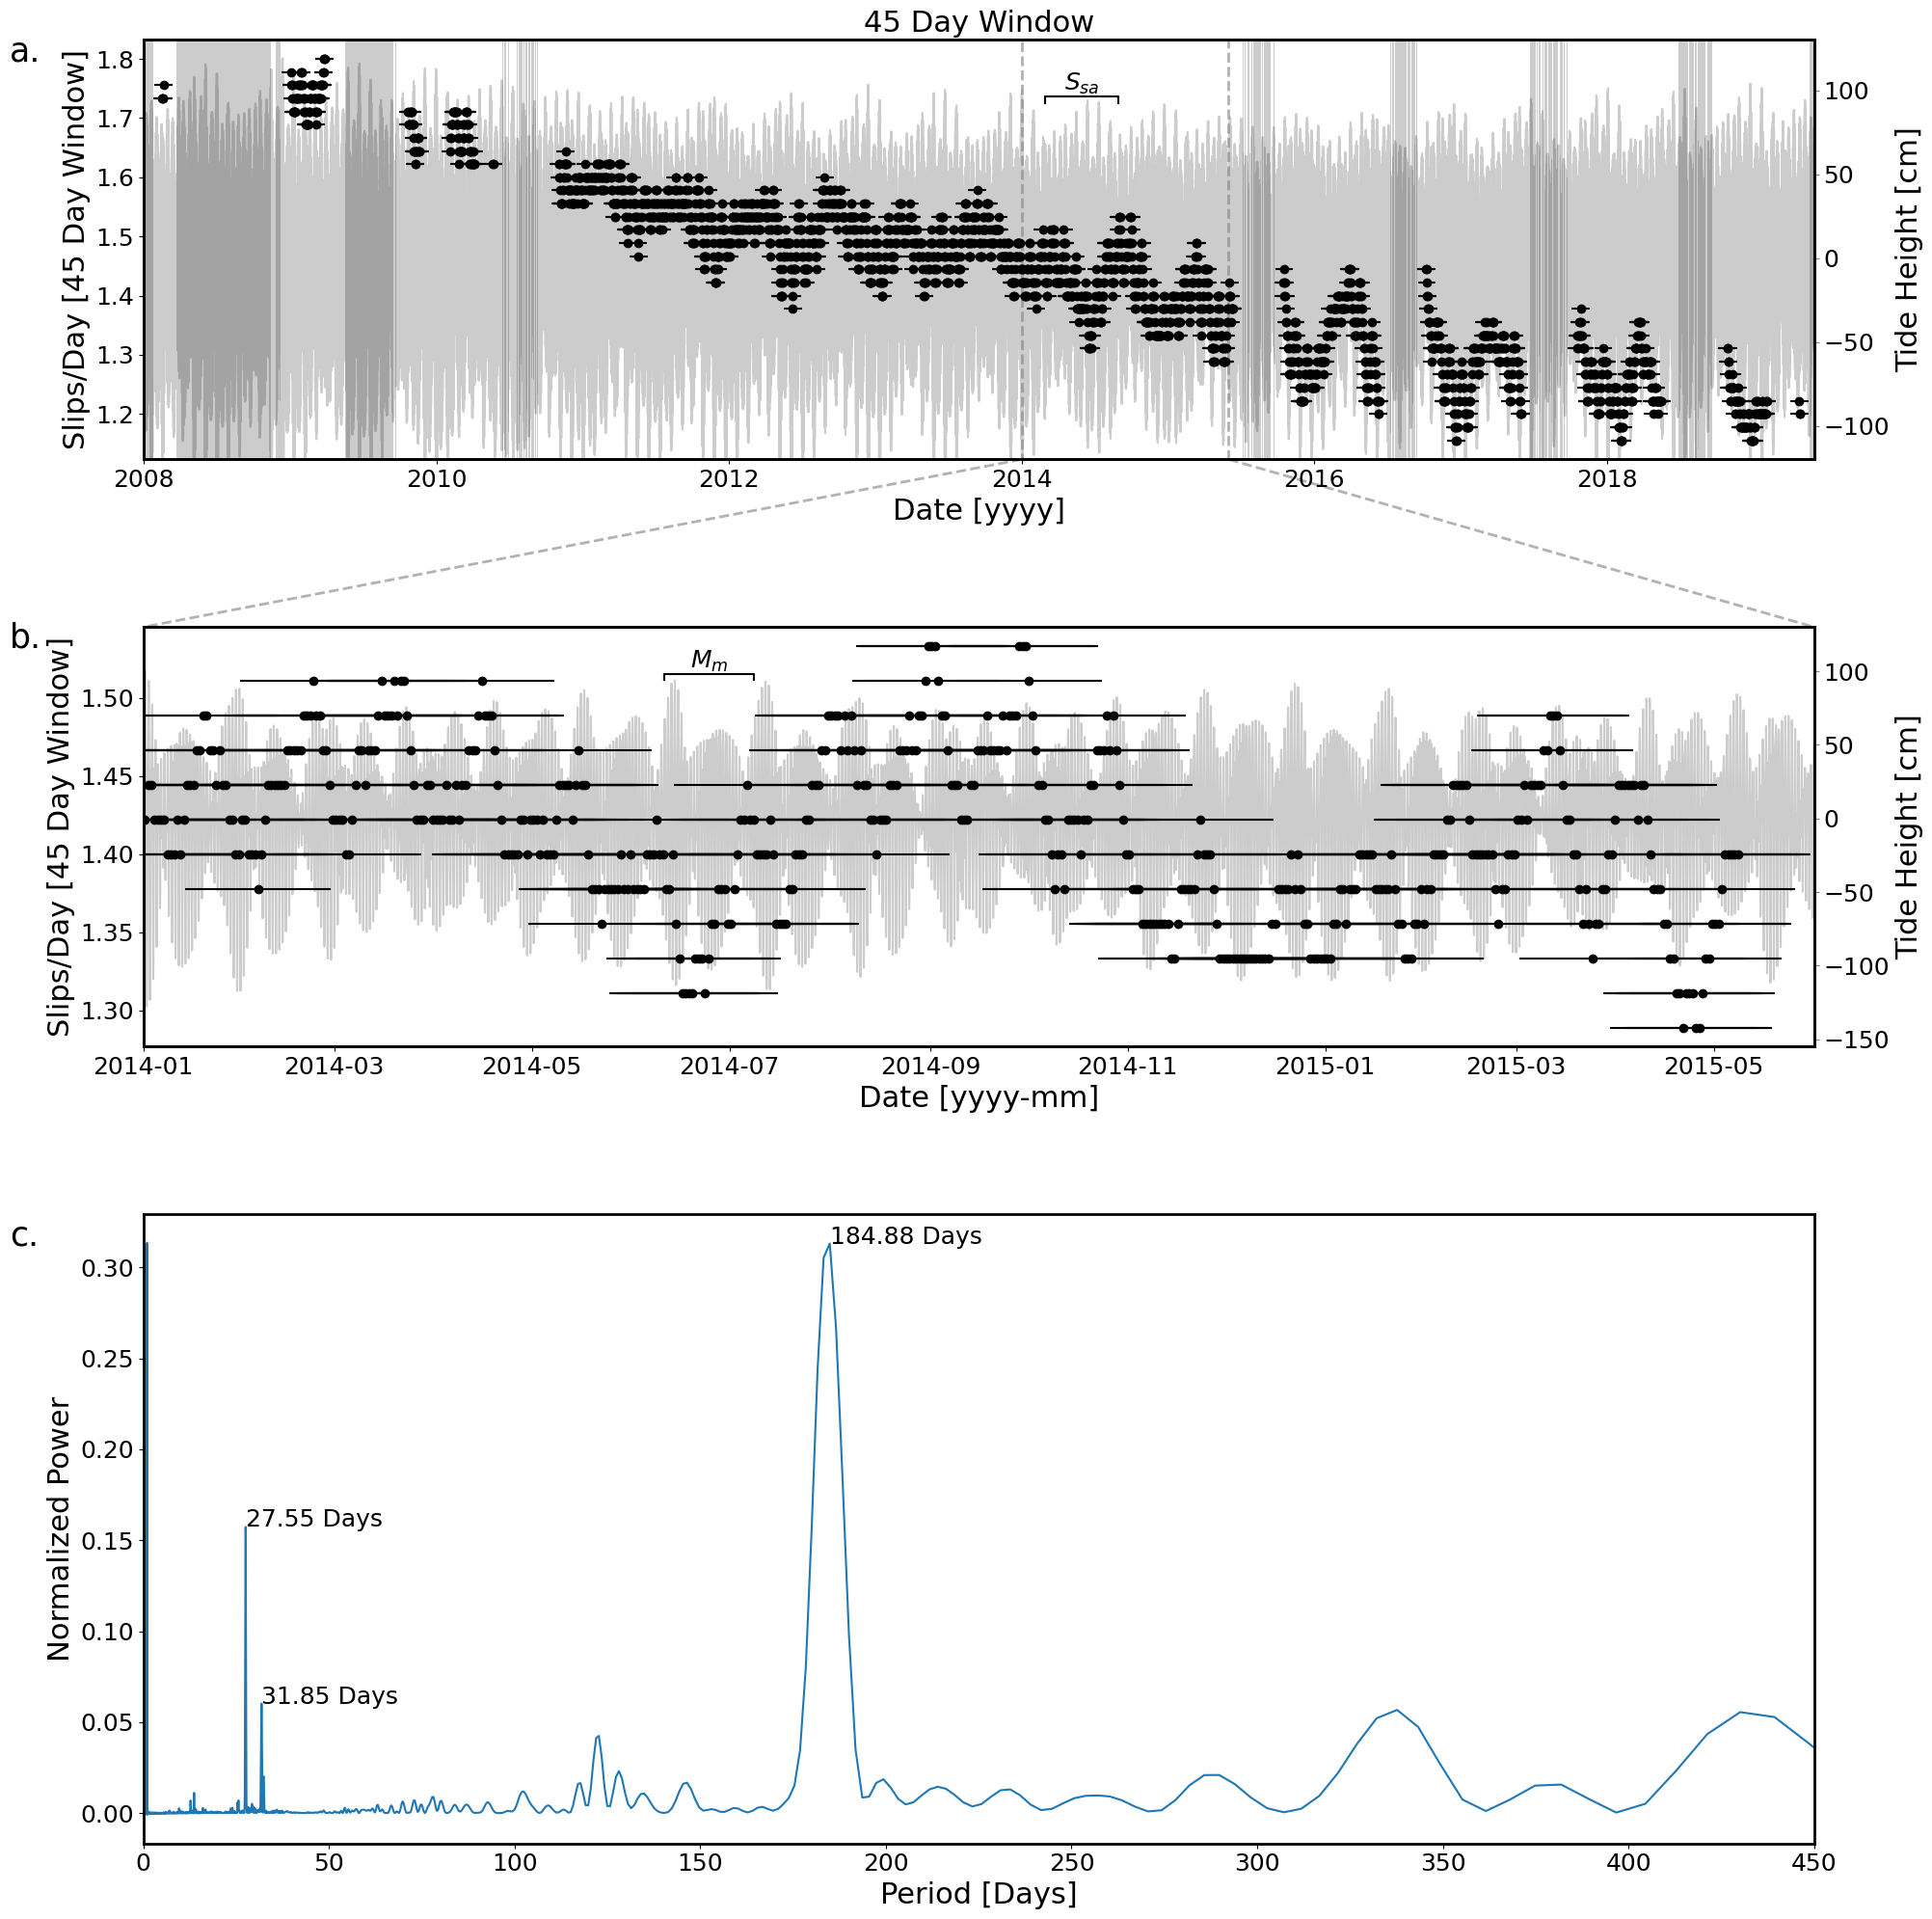

In [54]:
# Plot FIGS 4, S3, S4

SEC_TO_DAY = 3600 * 24
SEC_TO_HR = 3600
xlim = 450

viridis = mpl.colormaps["viridis"].resampled(20)
# Add window to rolling avg dict
for i, window in enumerate([3, 27, 45]):
    rolling_avg_dicts[i]["window"] = window


for rolling_avg_dict in rolling_avg_dicts:
    fig, (ax1, ax2, ax3) = plt.subplots(
        3,
        1,
        figsize=[20, 20],
        gridspec_kw={"height_ratios": [1, 1, 1.5]},
        layout="constrained",
    )
    skip_starts = rolling_avg_dict["skip_starts"]
    skip_ends = rolling_avg_dict["skip_ends"]
    skip_middles = rolling_avg_dict["skip_middles"]
    skips = rolling_avg_dict["skips"]
    tot_slips = rolling_avg_dict["tot_slips"]
    spacings = rolling_avg_dict["spacings"]
    window = rolling_avg_dict["window"]
    plot_rolling_avg_section(
        ax1,
        ax2,
        window,
        slide,
        skip_starts,
        skip_ends,
        skip_middles,
        skips,
        tot_slips,
        spacings,
    )

    # Lomb Scargle
    dates_as_sec = [a.timestamp() for a in skip_middles]
    tot_slips_masked = np.ma.masked_array(
        tot_slips, mask=np.invert(~np.isnan(tot_slips))
    )
    dates_as_sec_masked = np.ma.masked_array(
        dates_as_sec, mask=np.invert(~np.isnan(tot_slips))
    )
    tot_slips_masked = np.ma.compressed(tot_slips_masked)
    dates_as_sec_masked = np.ma.compressed(dates_as_sec_masked)
    tot_slips_detrended = scipy.signal.detrend(tot_slips_masked)

    # Spectrogram of rolling avg slips using lomb scargle
    frequency, power = LombScargle(dates_as_sec_masked, tot_slips_detrended).autopower()

    pks = scipy.signal.find_peaks(power[:10000], height=0.06)[0]
    # ax.plot(frequency[pks], power[pks], 'ro')
    period = 1 / frequency / SEC_TO_DAY  # Days
    ax3.plot(period, power)
    ax3.set_xlabel("Period [Days]", fontsize=22)
    ax3.set_ylabel("Normalized Power", fontsize=22)
    ax3.xaxis.set_tick_params(labelsize=18)
    ax3.yaxis.set_tick_params(labelsize=18)
    ax3.set_xlim(0, xlim)
    # ax.set_ylim(0,0.1)

    for pk, pwr in zip(period[pks], power[pks]):
        if pk < xlim:
            if pk > 0:
                print(f"{pk} Days, Power = {pwr}")
                ax3.text(pk + 0.001e-5, pwr, f"{pk:.2f} Days", fontsize=18)
            else:
                print(f"{pk} Hours, Power = {pwr}")
                ax3.text(pk + 0.001e-5, pwr, f"{pk:.2f} Hours", fontsize=18)

    ax1.annotate("a.", (-0.08, 0.95), xycoords="axes fraction", fontsize=25)
    ax2.annotate("b.", (-0.08, 0.95), xycoords="axes fraction", fontsize=25)
    ax3.annotate("c.", (-0.08, 0.95), xycoords="axes fraction", fontsize=25)

    st3 = datetime.datetime(2014, 1, 1)
    ed3 = datetime.datetime(2015, 6, 1)

    # Adds patch and zoom effect
    rect = plt.Rectangle(
        (st3, -200),
        ed3 - st3,
        1000,
        facecolor="none",
        zorder=0,
        alpha=0.3,
        edgecolor="black",
        linewidth=2,
        linestyle="--",
    )
    ax1.add_patch(rect)
    zoom_effect01(
        ax1,
        ax2,
        mdates.date2num(st3),
        mdates.date2num(ed3),
        ec="black",
        lw=2,
        alpha=0.3,
        ls="--",
    )
    fig.tight_layout()
    fig.savefig(f"Rolling_Avg_{window}_Day_Window.png")